In [ ]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/13/24/23cdf7e7dc33e5c01588c315f8424d31afa9edb05a80168f3d44f7178ff7/torchvision-0.16.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.1 MB 1.7 MB/s eta 0:00:01
   -------------------- ------------------- 0.6/1.1 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 9.0 MB/s eta 0:00:00


# Convolutional Networks

In this TP, you will delve into the world of convolutional networks (CNNs), a powerful class of neural networks specifically designed for tasks involving images. Convolutional networks have proven to be highly effective in image recognition, object detection, and various computer vision tasks due to their ability to capture spatial hierarchies and local patterns in the data.

## Task Overview

You will need to fill in the `CNNModel` class provided with your model architecture. This architecture should have at least 1 convolutional layer and a pooling layer.

Explain your choice in your report and why you decided to choose this architecture, with at least one sentence explaining each decision. For example, if you choose a CNN architecture with 2 convolutional layers, you will need to explain what the sizes involved are, what the purpose of each convolution is, etc.

Once you have assembled them into a complete convolutional network architecture, you will need to train it on CIFAR-10, which is a dataset of images with 10 classes. Your goal is to classify the classes. Track the performance and loss of your model on the training set and a validation set. You can use the validation set to stop training early if the validation loss is not improving.

After training your convolutional network, evaluate its performance on a separate test set. Analyze the results in your report. We encourage you to try different sets of hyperparameters and see how they influence the performance of your model. Report those results in your report.

Every time you see a `...` it means that you need to replace it with your own code.


In [ ]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The data

To begin, let's create a function that loads the CIFAR-10 dataset into three distinct loaders: train, test, and validation.


In [ ]:
def get_dataloaders(batch_size):
    # Define transformations
    # 1. convert to tensor
    # 2. normalize
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Load CIFAR10 dataset
    cifar_dataset = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    )

    # Define the size of your validation set
    validation_set_size = int(
        0.1 * len(cifar_dataset)
    )  # 10% of the training set for validation

    # Split the dataset into training and validation sets
    train_set, validation_set = random_split(
        cifar_dataset, [len(cifar_dataset) - validation_set_size, validation_set_size]
    )

    # Create DataLoader for training, validation, and test sets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

    # For the test set
    test_dataset = datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_dataloaders(batch_size=64)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


100%|██████████| 170498071/170498071 [00:01<00:00, 91253861.52it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Displaying Images with Class Names

Now, let's define a function that enables us to display images with their associated class names.


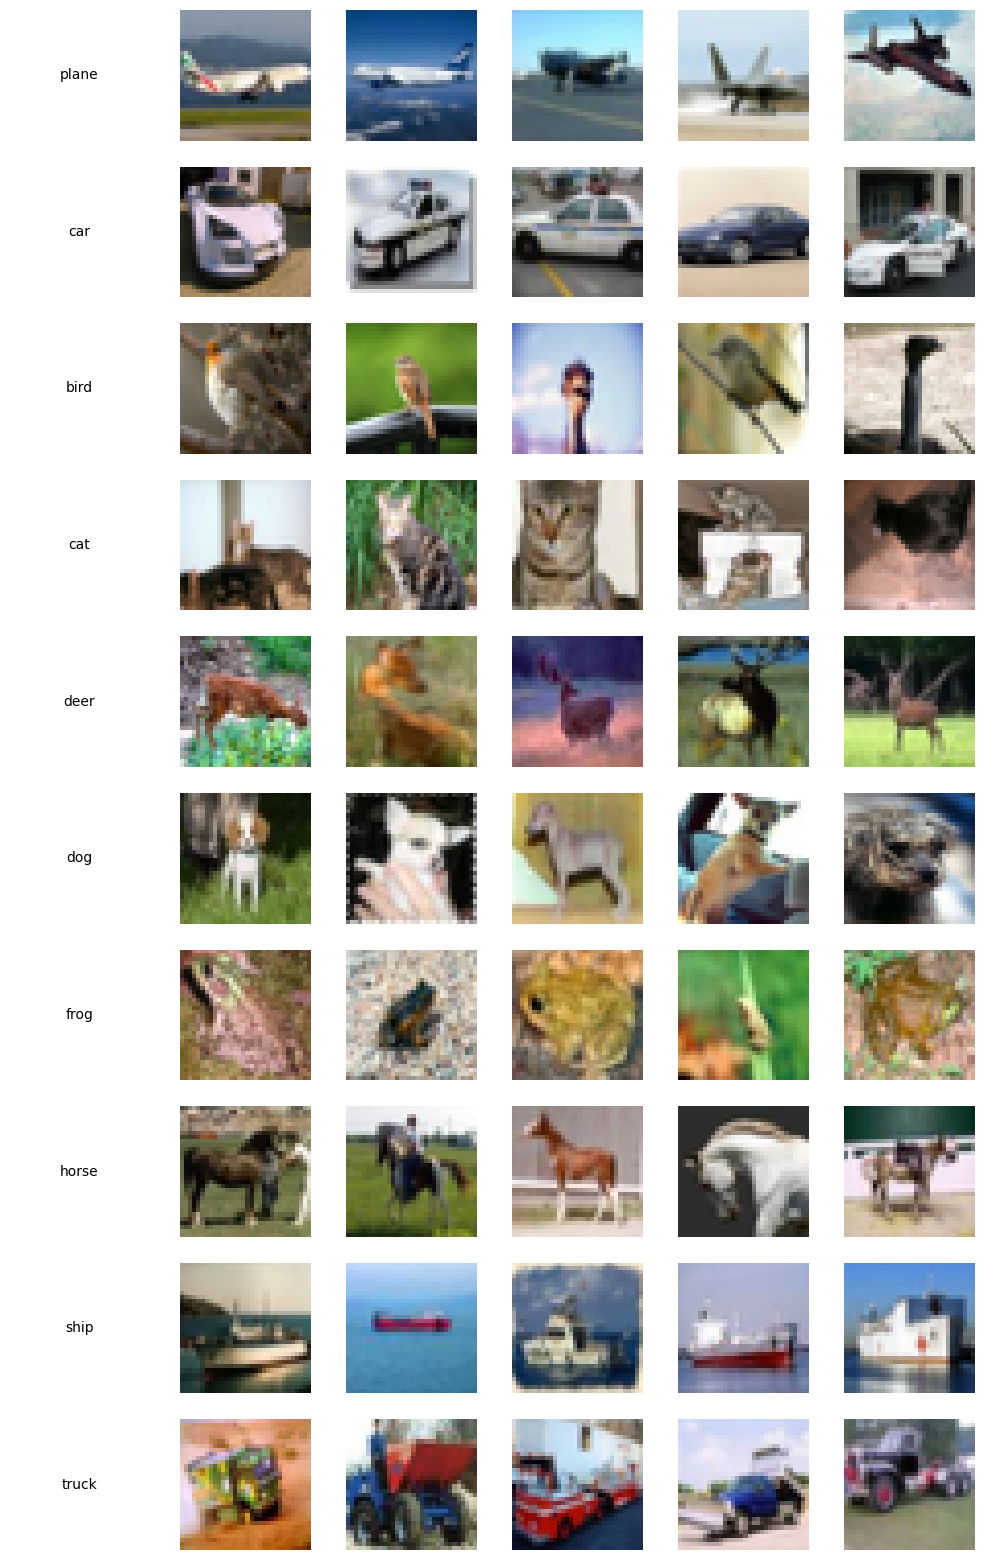

In [ ]:
# Function to display n images per class
def show_images_per_class(loader, class_labels=list(range(10)), n=5):
    class_count = len(class_labels)
    fig, axs = plt.subplots(class_count, n + 1, figsize=(n * 2.5, class_count * 2))

    for i, label in enumerate(class_labels):
        class_indices = [
            j
            for j, target in enumerate(loader.dataset.dataset.targets)
            if target == label
        ]
        selected_indices = np.random.choice(class_indices, n, replace=False)

        for j, index in enumerate(selected_indices):
            image, _ = loader.dataset.dataset[index]
            image = image.numpy().transpose((1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min())
            axs[i, j + 1].imshow(image)
            axs[i, j + 1].axis("off")

        # Display class label
        axs[i, 0].text(0.5, 0.5, classes[label], fontsize=10, ha="center", va="center")
        axs[i, 0].axis("off")

    plt.show()


number_of_images_per_class = 5  # Display 5 images per class

show_images_per_class(train_loader, n=number_of_images_per_class)


## Define Your CNN Model

Define your own CNN model in the code block below. Begin by specifying the layers of your model, and then describe how they should be used in the forward pass.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Première couche convolutionnelle
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        # Deuxième couche convolutionnelle
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        # Couche de pooling
        self.pool = nn.MaxPool2d(2, 2)
        # Couche entièrement connectée 1 (dimension à ajuster en fonction de la taille de l'image après les couches convolutionnelles et de pooling)
        self.fc1 = nn.Linear(8 * 8 * 64, 512)
        # Couche entièrement connectée 2
        self.fc2 = nn.Linear(512, 10) # 10 classes dans CIFAR-10

    def forward(self, x):
        # Appliquer conv1, ReLU et pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Appliquer conv2, ReLU et pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Aplatir les données pour la couche entièrement connectée
        x = x.view(-1, 8 * 8 * 64)
        # Appliquer fc1 et ReLU
        x = F.relu(self.fc1(x))
        # Appliquer fc2
        x = self.fc2(x)
        return x


Define the evaluate function, which takes a model, a data loader, a loss function, and a device as parameters. This function should return the loss and accuracy calculated over the provided data loader.


In [ ]:
def evaluate(model, data_loader, loss_fn, device):
    losses = []
    acc = []

    for i, data in enumerate(data_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # place data in the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            # forward
            outputs = model(inputs)

            # loss
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            acc.append(accuracy)

            # keep loss for plotting

            # keep accuracy for plotting


    return np.mean(losses), np.mean(acc)


## Training loop

In the following cell you will be implementing a training loop for a Convolutional Neural Network (CNN) using PyTorch. The provided code establishes the foundational structure, including setting hyperparameters, defining the model architecture, selecting an optimizer and loss function, and initiating the training loop. Your task is to fill in the missing parts marked with `...` to complete the implementation. Start by specifying the hyperparameters such as the number of epochs, batch size, and evaluation frequency. Next, define the architecture of the CNN model, choose an optimizer, and complete the forward pass, loss computation, and backward pass. The training loop keeps track of training loss and accuracy for later visualization. Additionally, the code supports evaluating the model on both the validation and, if desired, the test set during training.

Your are free to choose whatever hyperparameters you like, but you should motivate this choice on your report.


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

np.random.seed(13)

# define hyperparameters
epochs = 15
batch_size = 256
eval_every = 3  # number of epochs between evaluations
evaluate_testset_during_training = True  # whether to evaluate the testset during training (True or False)
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # use GPU if available


# get dataloaders
train_loader, validation_loader, test_loader = get_dataloaders(batch_size=batch_size)

# define model
model = CNNModel().to(device)

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()


# define variables to store loss and accuracy
train_history_loss = []
train_history_acc = []
val_history_loss = []
val_history_acc = []
test_history_loss = []
test_history_acc = []

for epoch in range(1, epochs + 1):
    model.train()

    train_loss = []
    train_acc = []

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # place data in the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)

        # loss
        loss = loss_fn(outputs, labels)
        train_loss.append(loss.item())

        # backward
        loss.backward()

        # optimize
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)


        # keep loss for plotting


        # keep accuracy for plotting
        train_acc.append(accuracy)

    train_history_loss.append(np.mean(train_loss))
    train_history_acc.append(np.mean(train_acc))

    print(
        "[TRAIN]Epoch {:>3}/{:>3}, loss {:.4f}, acc {:.2f}".format(
            epoch, epochs, train_history_loss[-1], train_history_acc[-1]
        )
    )

    if epoch % eval_every == 0:
        model.eval()
        val_loss, val_acc = evaluate(model, validation_loader, loss_fn, device)
        val_history_loss.append(val_loss)
        val_history_acc.append(val_acc)

        print(
            "[VAL]Epoch {:>3}/{:>3}, loss {:.4f}, acc {:.2f}".format(
                epoch, epochs, val_history_loss[-1], val_history_acc[-1]
            )
        )

        if evaluate_testset_during_training:
            test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
            test_history_loss.append(test_loss)
            test_history_acc.append(test_acc)

"""
Key Components of the Code:
Training Loop: For each epoch, the model is set to training mode using model.train(), and the training data is processed batch by batch.
Forward Pass: The model makes predictions based on the input data.
Loss Calculation: The loss is computed using the CrossEntropyLoss function, which is standard for classification tasks.
Backward Pass: Backpropagation is performed by calling loss.backward().
Optimization: The optimizer updates the model parameters.
Accuracy Calculation: The accuracy for each batch is calculated and stored.
Validation and Test Evaluation: At specified intervals (determined by eval_every), the model is evaluated on the validation set, and optionally on the test set if evaluate_testset_during_training is set to True.
"""


Files already downloaded and verified
Files already downloaded and verified
[TRAIN]Epoch   1/ 15, loss 1.4859, acc 0.47
[TRAIN]Epoch   2/ 15, loss 1.1039, acc 0.61
[TRAIN]Epoch   3/ 15, loss 0.9376, acc 0.67
[VAL]Epoch   3/ 15, loss 0.9417, acc 0.67
[TRAIN]Epoch   4/ 15, loss 0.8075, acc 0.72
[TRAIN]Epoch   5/ 15, loss 0.7125, acc 0.75
[TRAIN]Epoch   6/ 15, loss 0.6049, acc 0.79
[VAL]Epoch   6/ 15, loss 0.8443, acc 0.71
[TRAIN]Epoch   7/ 15, loss 0.5171, acc 0.82
[TRAIN]Epoch   8/ 15, loss 0.4242, acc 0.86
[TRAIN]Epoch   9/ 15, loss 0.3339, acc 0.89
[VAL]Epoch   9/ 15, loss 0.9090, acc 0.72
[TRAIN]Epoch  10/ 15, loss 0.2447, acc 0.92
[TRAIN]Epoch  11/ 15, loss 0.1745, acc 0.95
[TRAIN]Epoch  12/ 15, loss 0.1160, acc 0.97
[VAL]Epoch  12/ 15, loss 1.1486, acc 0.72
[TRAIN]Epoch  13/ 15, loss 0.0710, acc 0.98
[TRAIN]Epoch  14/ 15, loss 0.0439, acc 0.99
[TRAIN]Epoch  15/ 15, loss 0.0323, acc 0.99
[VAL]Epoch  15/ 15, loss 1.4387, acc 0.71


'\nKey Components of the Code:\nTraining Loop: For each epoch, the model is set to training mode using model.train(), and the training data is processed batch by batch.\nForward Pass: The model makes predictions based on the input data.\nLoss Calculation: The loss is computed using the CrossEntropyLoss function, which is standard for classification tasks.\nBackward Pass: Backpropagation is performed by calling loss.backward().\nOptimization: The optimizer updates the model parameters.\nAccuracy Calculation: The accuracy for each batch is calculated and stored.\nValidation and Test Evaluation: At specified intervals (determined by eval_every), the model is evaluated on the validation set, and optionally on the test set if evaluate_testset_during_training is set to True.\n'

Show losses history for train, validation and test set in same plot


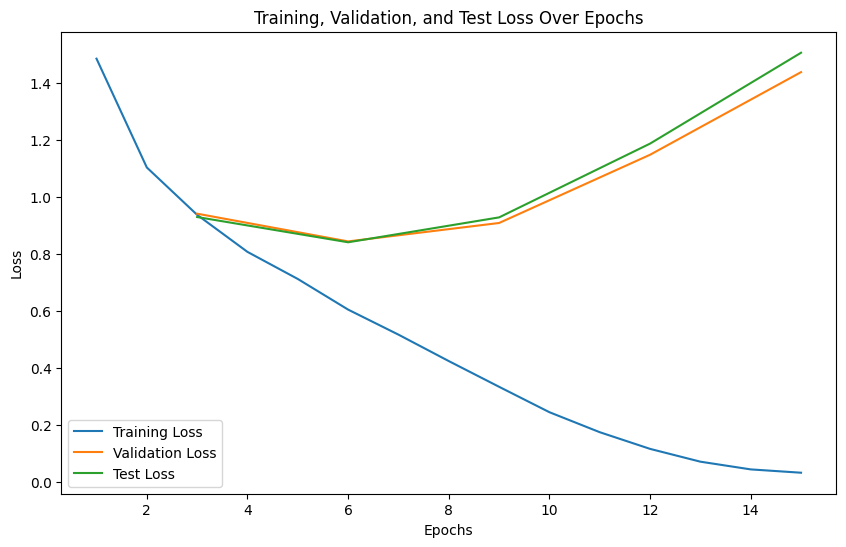

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_history_loss, val_history_loss, and test_history_loss are lists containing loss values
epochs_range = range(1, epochs + 1)
eval_epochs_range = range(eval_every, epochs + 1, eval_every)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_history_loss, label='Training Loss')
plt.plot(eval_epochs_range, val_history_loss, label='Validation Loss')

# Test loss is plotted against the epochs where evaluation occurred
if evaluate_testset_during_training:
    plt.plot(eval_epochs_range, test_history_loss, label='Test Loss')

plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Show accuracy history for train, validation and test set in same plot


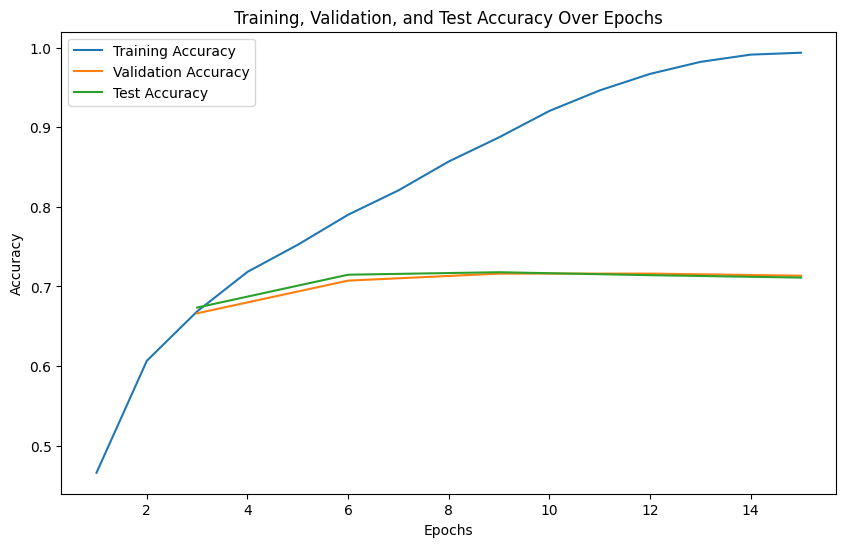

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_history_acc, val_history_acc, and test_history_acc are lists containing accuracy values
epochs_range = range(1, epochs + 1)
eval_epochs_range = range(eval_every, epochs + 1, eval_every)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_history_acc, label='Training Accuracy')
plt.plot(eval_epochs_range, val_history_acc, label='Validation Accuracy')

# Test accuracy is plotted against the epochs where evaluation occurred
if evaluate_testset_during_training:
    plt.plot(eval_epochs_range, test_history_acc, label='Test Accuracy')

plt.title('Training, Validation, and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


*Report* final accuracy on each set


In [ ]:
# Assuming train_history_acc, val_history_acc, and test_history_acc contain the accuracy history
final_train_accuracy = train_history_acc[-1] if train_history_acc else None
final_val_accuracy = val_history_acc[-1] if val_history_acc else None
final_test_accuracy = test_history_acc[-1] if test_history_acc else None

print(f"Final Training Accuracy: {100 *final_train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {100 *final_val_accuracy:.2f}%")
print(f"Final Test Accuracy: {100 *final_test_accuracy:.2f}%")


Final Training Accuracy: 99.38%
Final Validation Accuracy: 71.35%
Final Test Accuracy: 71.11%


Now we can verify the accuracy of our model in a per class basis. You can simply modify the code present in the evaluate class to track the accuracy of the model for each class instead of the overall accuracy. Don't modify directly the evaluate function, instead copy it in the following cell and adapt it as need.

The output should be something like the following:  
Accuracy for class: plane = ... %  
Accuracy for class: car = ... %  
Accuracy for class: bird = ... %  
Accuracy for class: cat = ... %  
Accuracy for class: deer = ... %  
Accuracy for class: dog = ... %  
Accuracy for class: frog = ... %  
Accuracy for class: horse = ... %  
Accuracy for class: ship = ... %  
Accuracy for class: truck = ... %


In [ ]:
import numpy as np
import torch

def evaluate_per_class(model, data_loader, device):
  # Initialisation des compteurs pour chaque classe
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Désactivation du calcul du gradient pour l'évaluation
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # Calcul des prédictions du modèle
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            # Mise à jour des compteurs de précision pour chaque classe
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

     # Affichage de la précision pour chaque classe
    for i in range(10):
        print(f'Accuracy for class: {classes[i]} = {(100 * class_correct[i] / class_total[i]):.2f} %')

# Appel de la fonction avec notre model et nos données:
evaluate_per_class(model, test_loader, device)



Accuracy for class: plane = 72.00 %
Accuracy for class: car = 82.00 %
Accuracy for class: bird = 65.20 %
Accuracy for class: cat = 59.00 %
Accuracy for class: deer = 63.70 %
Accuracy for class: dog = 56.90 %
Accuracy for class: frog = 77.90 %
Accuracy for class: horse = 74.30 %
Accuracy for class: ship = 84.50 %
Accuracy for class: truck = 79.20 %
